In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.metrics import mean_absolute_error
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api 
from pmdarima import auto_arima

## Data Set Up

In [2]:
# Import Data
us_diff = pd.read_csv('univariate_datasets/us_diff.csv', usecols=[1,2], index_col=0, parse_dates=[0])
us = pd.read_csv('univariate_datasets/univariate_df_United_States.csv',usecols=[1,2], index_col=0, parse_dates=[0])
belgium = pd.read_csv('univariate_datasets/univariate_df_Belgium.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
chile = pd.read_csv('univariate_datasets/univariate_df_Chile.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
czechia = pd.read_csv('univariate_datasets/univariate_df_Czechia.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
estonia = pd.read_csv('univariate_datasets/univariate_df_Estonia.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
france = pd.read_csv('univariate_datasets/univariate_df_France.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
ireland = pd.read_csv('univariate_datasets/univariate_df_Ireland.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
israel = pd.read_csv('univariate_datasets/univariate_df_Israel.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
italy = pd.read_csv('univariate_datasets/univariate_df_Italy.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
malaysia = pd.read_csv('univariate_datasets/univariate_df_Malaysia.csv', usecols=[1,2], index_col = 0, parse_dates = [0])
# test_train split


czechia_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal', 'auto'])
czechia_df['actual'] = czechia['new_deaths']
estonia_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
estonia_df['actual'] = estonia['new_deaths']
france_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
france_df['actual'] = france['new_deaths']
malaysia_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal', 'auto'])
malaysia_df['actual'] = malaysia['new_deaths']
us_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
us_df['actual'] = us['new_deaths']
belgium_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
belgium_df['actual'] = belgium['new_deaths']
chile_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
chile_df['actual'] = chile['new_deaths']
ireland_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
ireland_df['actual'] = ireland['new_deaths']
israel_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
israel_df['actual'] = israel['new_deaths']
italy_df = pd.DataFrame(columns = ['actual','baseline', 'grid_search', 'seasonal','auto'])
italy_df['actual'] = italy['new_deaths']

mase = MeanAbsoluteScaledError(sp=13)


evaluation = pd.DataFrame(columns = ['Country','Model', 'MAE', 'MASE'])

# US

,Country,Model,MAE,MASE
0,US,Baseline ARIMA,391.961990,0.553033
1,US,Grid Search ARIMA,451.420143,0.636924
2,US,Seasonal ARIMA,414.311591,0.584567
3,US,Auto ARIMA,374.330405,0.528156


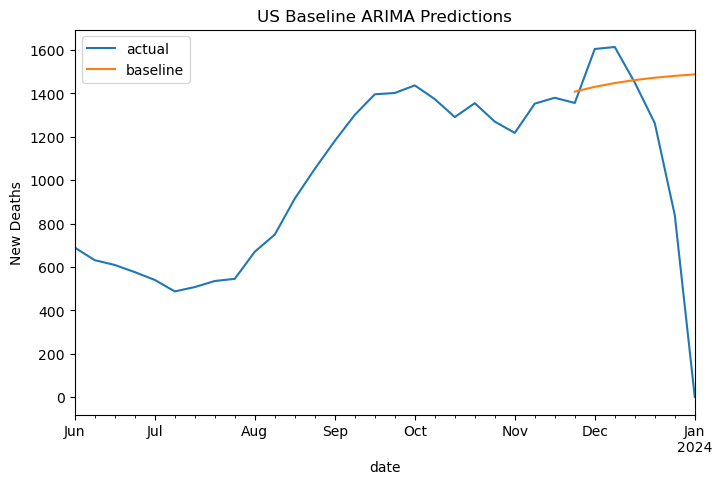

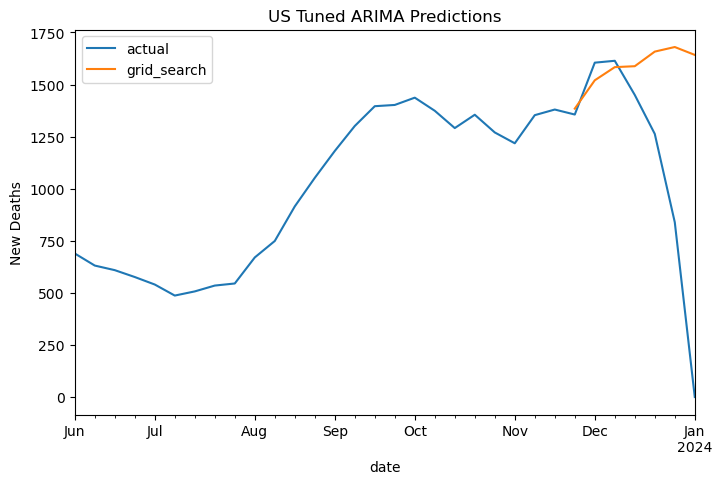

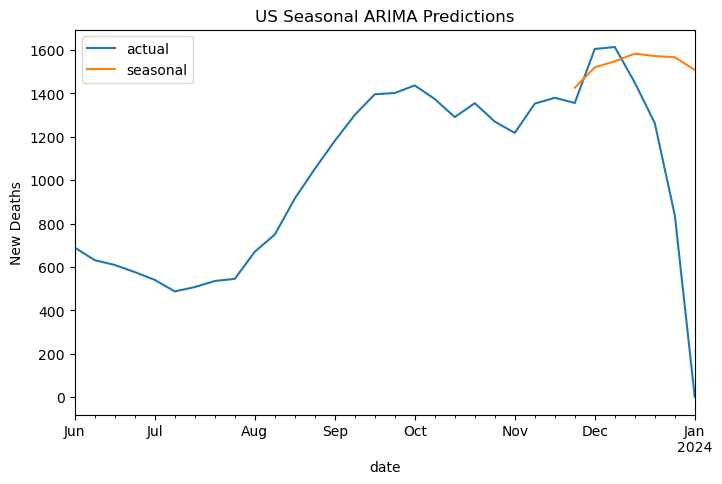

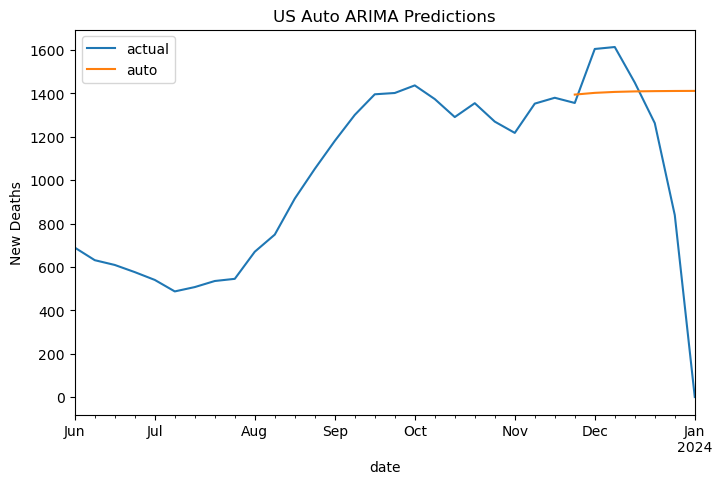

In [3]:
# train test split
# get only dates past june 1 2023
df = us
df = df[df.index > '2023-06-01']
end = len(df) -1
train_size = int(len(df)*0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
#baseline
model = ARIMA(train['new_deaths'], order=(1,1,1))
model_fit = model.fit()
pred=model_fit.predict(start=train_size,end = end, dynamic=True)
us_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#grid search for p and q 
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(train['new_deaths'], order=(p,1,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df = results_df.sort_values('aic')
p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
model = ARIMA(train['new_deaths'], order=(p,1,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end = end,dynamic=True)
us_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])
#seasonal ARIMA
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 1, q),seasonal_order=(P,1,Q,13))
model_fit=model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
us_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods=len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
us_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#plots
# plot after the date june 1 2023

us_df[us_df.index > '2023-06-01'][['actual','baseline']].plot(figsize=(8,5))
plt.title('US Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

us_df[us_df.index > '2023-06-01'][['actual','grid_search']].plot(figsize=(8,5))
plt.title('US Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

us_df[us_df.index > '2023-06-01'][['actual','seasonal']].plot(figsize=(8,5))
plt.title('US Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

us_df[us_df.index > '2023-06-01'][['actual','auto']].plot(figsize=(8,5))
plt.title('US Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country':'US', 'Model':'Baseline ARIMA', 'MAE':baseline_mae, 'MASE':baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'US', 'Model':'Grid Search ARIMA', 'MAE':grid_search_mae, 'MASE':grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'US', 'Model':'Seasonal ARIMA', 'MAE':seasonal_mae, 'MASE':seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'US', 'Model':'Auto ARIMA', 'MAE':auto_mae, 'MASE':auto_mape}, ignore_index=True)
evaluation

# Belgium

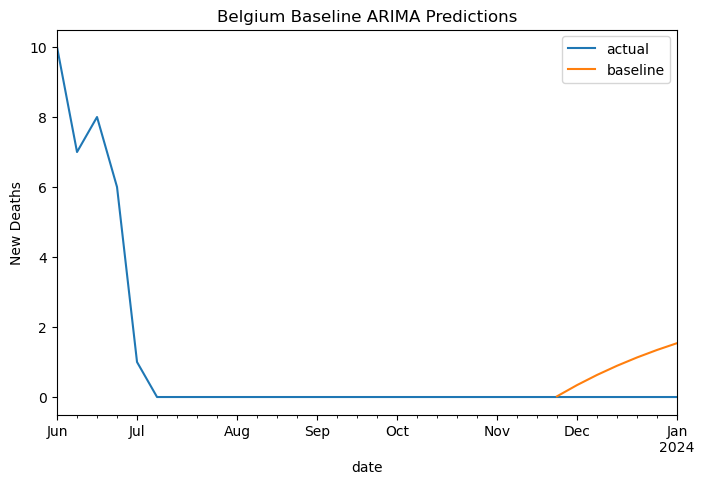

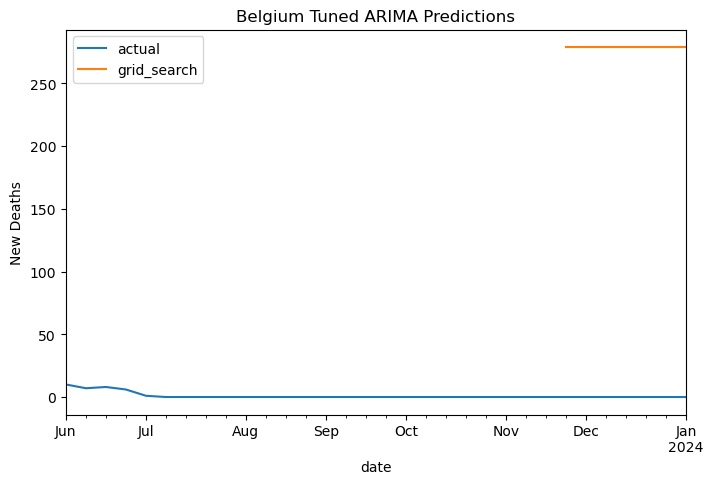

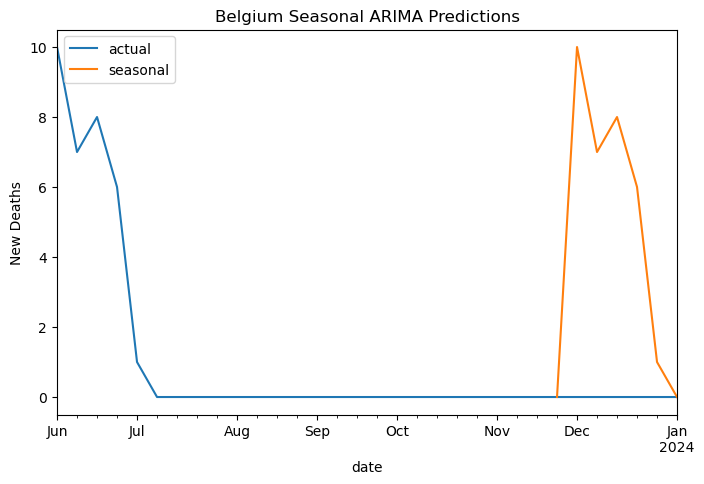

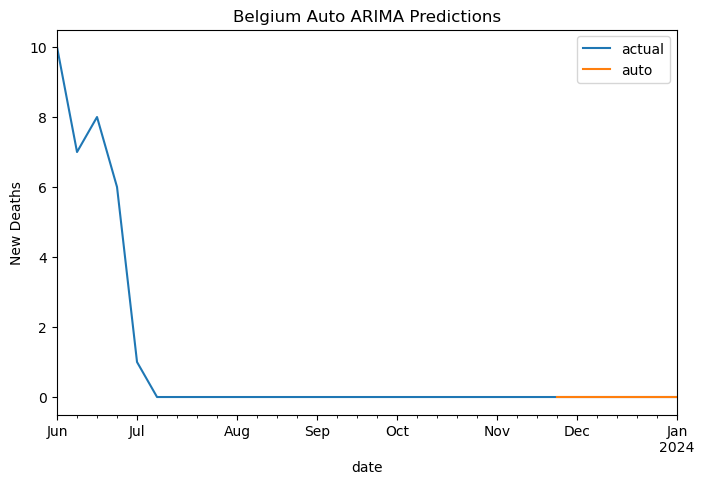

In [4]:
# train test split
df = belgium
df = df[df.index > '2023-06-01']
end = len(df) -1
train_size = int(len(df)*0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
#baseline
model = ARIMA(train['new_deaths'], order=(1,0,1))
model_fit = model.fit()
pred=model_fit.predict(start=train_size,end = end, dynamic=True)
belgium_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#grid search for p and q 
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(train['new_deaths'], order=(p,0,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df = results_df.sort_values('aic')
p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
model = ARIMA(train['new_deaths'], order=(p,0,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end = end,dynamic=True)
belgium_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])
#seasonal ARIMA
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,0,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 0, q),seasonal_order=(P,1,Q,13))
model_fit=model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
belgium_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods=len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
belgium_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#plots
# plot after the date june 1 2023

belgium_df[belgium_df.index > '2023-06-01'][['actual','baseline']].plot(figsize=(8,5))
plt.title('Belgium Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

belgium_df[belgium_df.index > '2023-06-01'][['actual','grid_search']].plot(figsize=(8,5))
plt.title('Belgium Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

belgium_df[belgium_df.index > '2023-06-01'][['actual','seasonal']].plot(figsize=(8,5))
plt.title('Belgium Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

belgium_df[belgium_df.index > '2023-06-01'][['actual','auto']].plot(figsize=(8,5))
plt.title('Belgium Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country':'Belgium', 'Model':'Baseline ARIMA', 'MAE':baseline_mae, 'MASE':baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Belgium', 'Model':'Grid Search ARIMA', 'MAE':grid_search_mae, 'MASE':grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Belgium', 'Model':'Seasonal ARIMA', 'MAE':seasonal_mae, 'MASE':seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Belgium', 'Model':'Auto ARIMA', 'MAE':auto_mae, 'MASE':auto_mape}, ignore_index=True)


# Chile

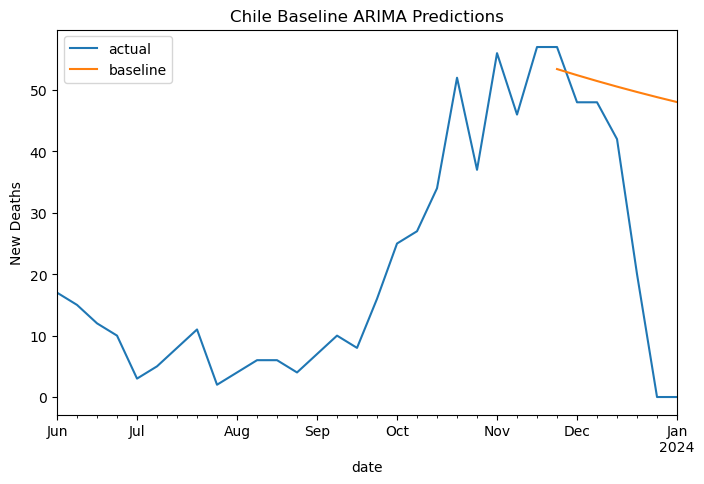

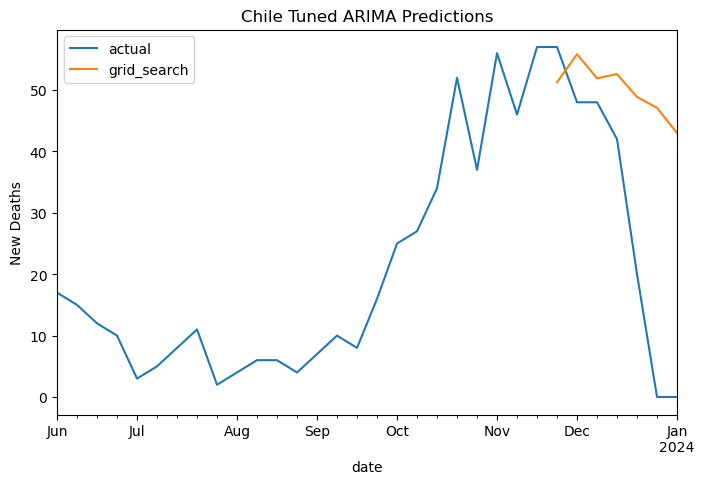

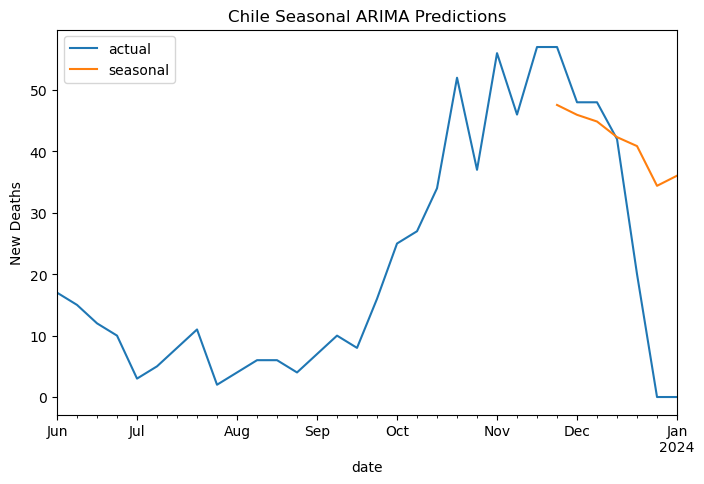

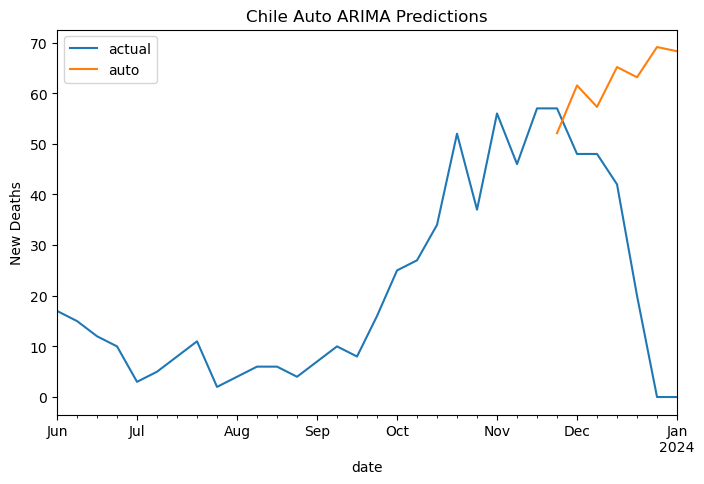

In [5]:
# train test split
# get only dates past june 1 2023
df = chile
df = df[df.index > '2023-06-01']
end = len(df) -1
train_size = int(len(df)*0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
#baseline
model = ARIMA(train['new_deaths'], order=(1,0,1))
model_fit = model.fit()
pred=model_fit.predict(start=train_size,end = end, dynamic=True)
chile_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#grid search for p and q 
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(train['new_deaths'], order=(p,0,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df = results_df.sort_values('aic')
p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
model = ARIMA(train['new_deaths'], order=(p,0,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end = end,dynamic=True)
chile_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])
#seasonal ARIMA
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,0,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 0, q),seasonal_order=(P,1,Q,13))
model_fit=model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
chile_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods=len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
chile_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#plots
# plot after the date june 1 2023

chile_df[chile_df.index > '2023-06-01'][['actual','baseline']].plot(figsize=(8,5))
plt.title('Chile Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

chile_df[chile_df.index > '2023-06-01'][['actual','grid_search']].plot(figsize=(8,5))
plt.title('Chile Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

chile_df[chile_df.index > '2023-06-01'][['actual','seasonal']].plot(figsize=(8,5))
plt.title('Chile Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

chile_df[chile_df.index > '2023-06-01'][['actual','auto']].plot(figsize=(8,5))
plt.title('Chile Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country':'Chile', 'Model':'Baseline ARIMA', 'MAE':baseline_mae, 'MASE':baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Chile', 'Model':'Grid Search ARIMA', 'MAE':grid_search_mae, 'MASE':grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Chile', 'Model':'Seasonal ARIMA', 'MAE':seasonal_mae, 'MASE':seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Chile', 'Model':'Auto ARIMA', 'MAE':auto_mae, 'MASE':auto_mape}, ignore_index=True)

# Czechia

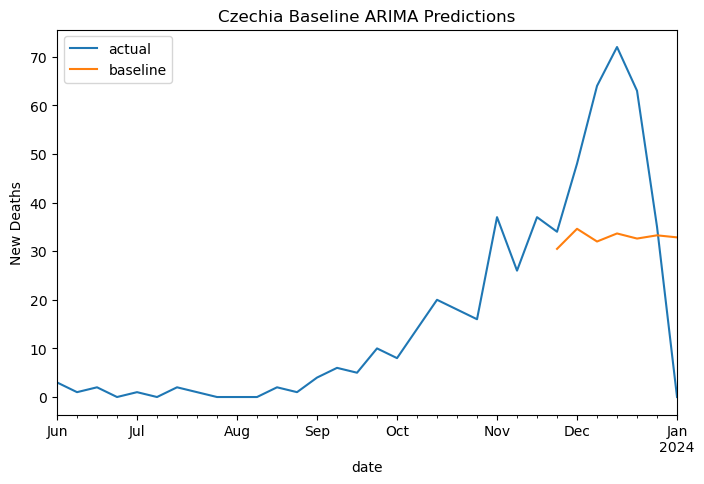

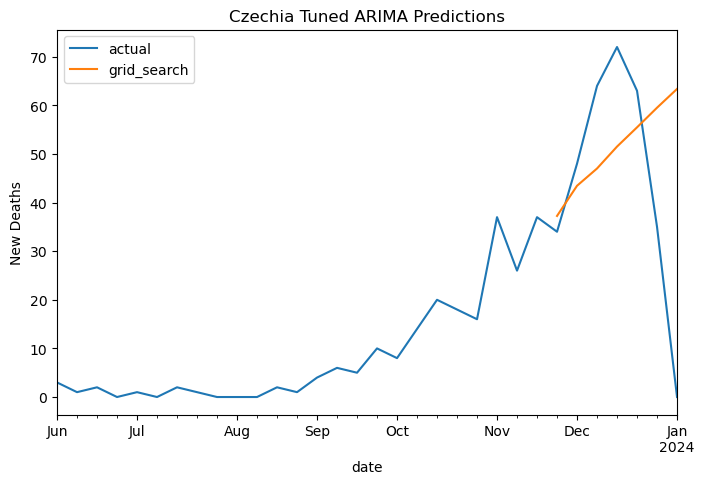

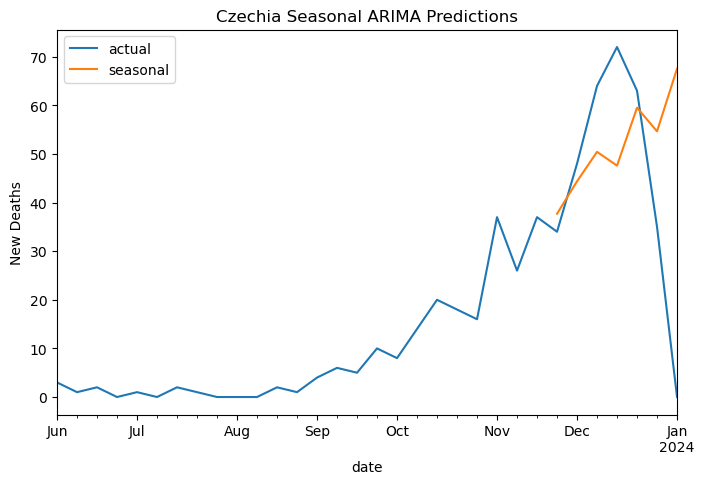

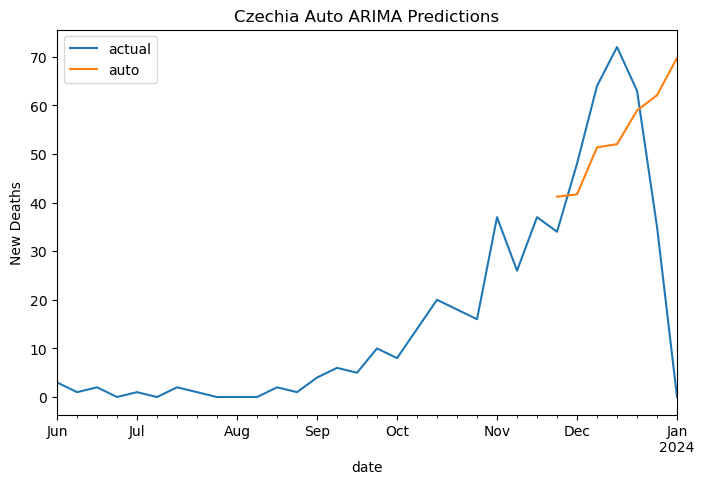

In [6]:
# train test split
# get only dates past june 1 2023
df = czechia
df = df[df.index > '2023-06-01']
end = len(df) -1
train_size = int(len(df)*0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
#baseline
model = ARIMA(train['new_deaths'], order=(1,1,1))
model_fit = model.fit()
pred=model_fit.predict(start=train_size,end = end, dynamic=True)
czechia_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#grid search for p and q 
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(train['new_deaths'], order=(p,1,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df = results_df.sort_values('aic')
p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
model = ARIMA(train['new_deaths'], order=(p,1,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end = end,dynamic=True)
czechia_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])
#seasonal ARIMA
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 1, q),seasonal_order=(P,1,Q,13))
model_fit=model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
czechia_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods=len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
czechia_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#plots
# plot after the date june 1 2023

czechia_df[czechia_df.index > '2023-06-01'][['actual','baseline']].plot(figsize=(8,5))
plt.title('Czechia Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

czechia_df[czechia_df.index > '2023-06-01'][['actual','grid_search']].plot(figsize=(8,5))
plt.title('Czechia Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

czechia_df[czechia_df.index > '2023-06-01'][['actual','seasonal']].plot(figsize=(8,5))
plt.title('Czechia Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

czechia_df[czechia_df.index > '2023-06-01'][['actual','auto']].plot(figsize=(8,5))
plt.title('Czechia Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country':'Czechia', 'Model':'Baseline ARIMA', 'MAE':baseline_mae, 'MASE':baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Czechia', 'Model':'Grid Search ARIMA', 'MAE':grid_search_mae, 'MASE':grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Czechia', 'Model':'Seasonal ARIMA', 'MAE':seasonal_mae, 'MASE':seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Czechia', 'Model':'Auto ARIMA', 'MAE':auto_mae, 'MASE':auto_mape}, ignore_index=True)


# Estonia

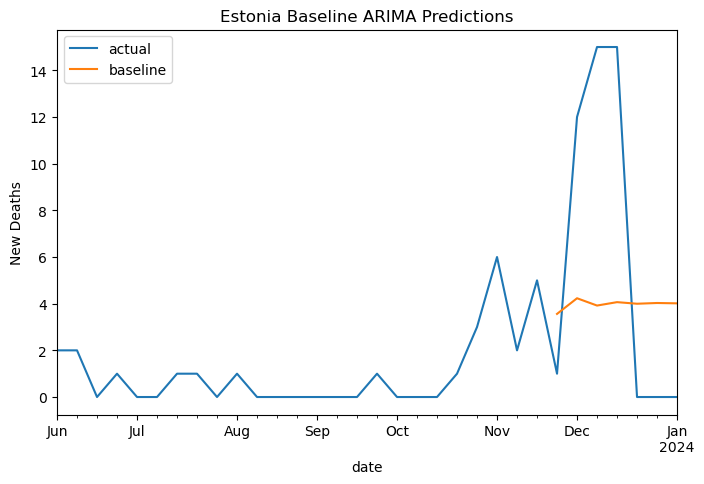

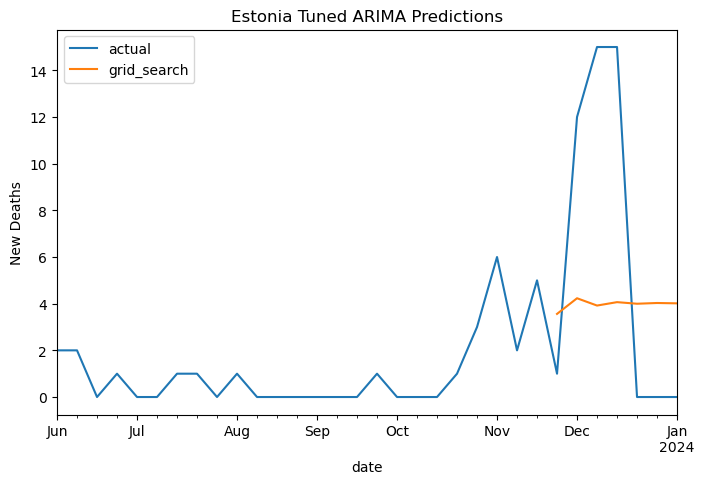

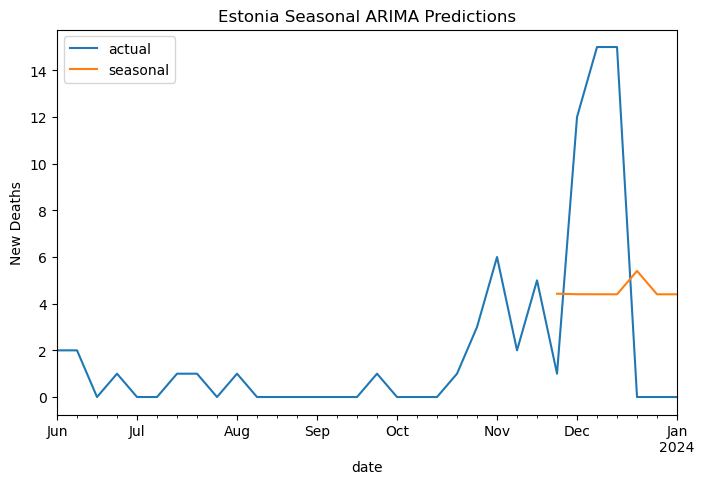

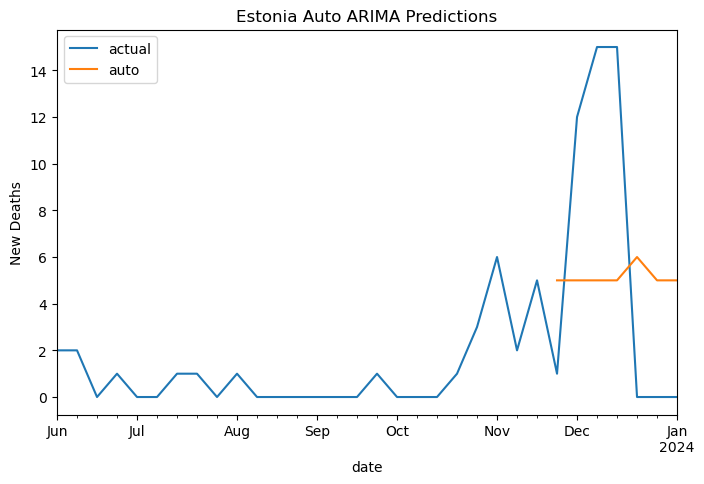

In [7]:
# train test split
# get only dates past june 1 2023
df = estonia
df = df[df.index > '2023-06-01']
end = len(df) -1
train_size = int(len(df)*0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
#baseline
model = ARIMA(train['new_deaths'], order=(1,1,1))
model_fit = model.fit()
pred=model_fit.predict(start=train_size,end = end, dynamic=True)
estonia_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#grid search for p and q 
results = []
for p in range(1,5):
    for q in range(1,5): 
        model = ARIMA(train['new_deaths'], order=(p,1,q)).fit()
        results.append([p,q,model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p','q','aic']
results_df = results_df.sort_values('aic')
p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
model = ARIMA(train['new_deaths'], order=(p,1,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end = end,dynamic=True)
estonia_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])
#seasonal ARIMA
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore",category =  UserWarning)
warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results=[]
    for p in range(1,3):
        for q in range(1,3):
            for P in range(1,3):
                for Q in range(1,3):
                    model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p,q,P,Q,model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 1, q),seasonal_order=(P,1,Q,13))
model_fit=model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
estonia_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods=len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
estonia_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train = train['new_deaths'])

#plots
# plot after the date june 1 2023

estonia_df[estonia_df.index > '2023-06-01'][['actual','baseline']].plot(figsize=(8,5))
plt.title('Estonia Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

estonia_df[estonia_df.index > '2023-06-01'][['actual','grid_search']].plot(figsize=(8,5))
plt.title('Estonia Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

estonia_df[estonia_df.index > '2023-06-01'][['actual','seasonal']].plot(figsize=(8,5))
plt.title('Estonia Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

estonia_df[estonia_df.index > '2023-06-01'][['actual','auto']].plot(figsize=(8,5))
plt.title('Estonia Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country':'Estonia', 'Model':'Baseline ARIMA', 'MAE':baseline_mae, 'MASE':baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Estonia', 'Model':'Grid Search ARIMA', 'MAE':grid_search_mae, 'MASE':grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Estonia', 'Model':'Seasonal ARIMA', 'MAE':seasonal_mae, 'MASE':seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country':'Estonia', 'Model':'Auto ARIMA', 'MAE':auto_mae, 'MASE':auto_mape}, ignore_index=True)


# France

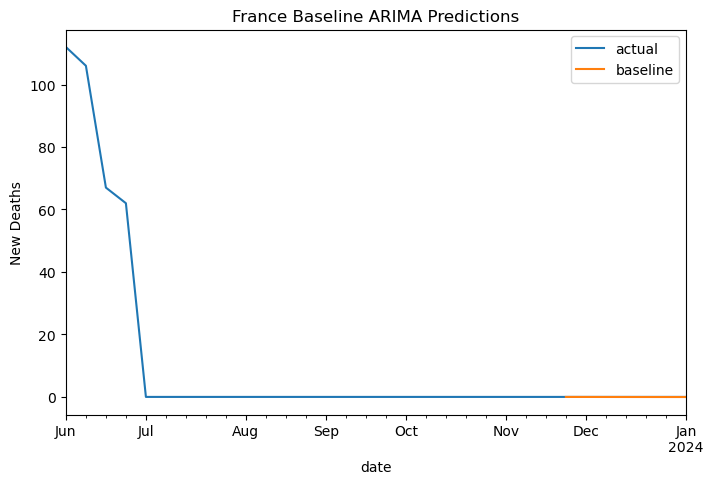

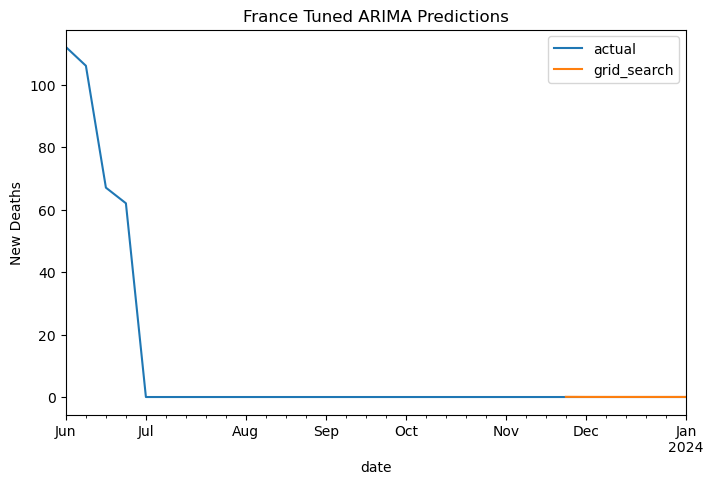

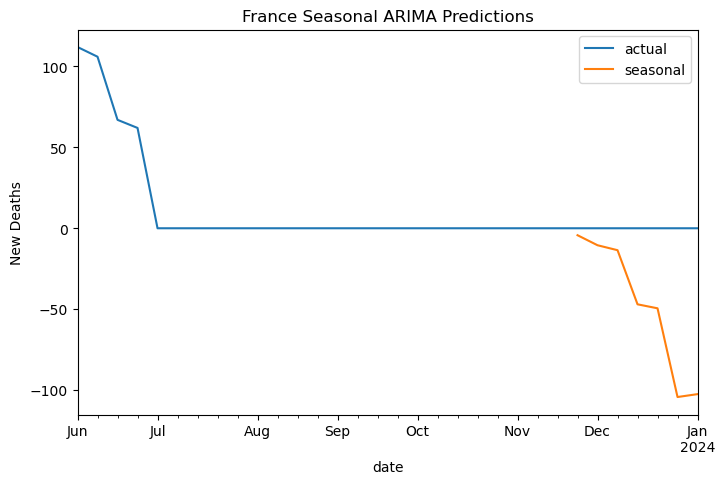

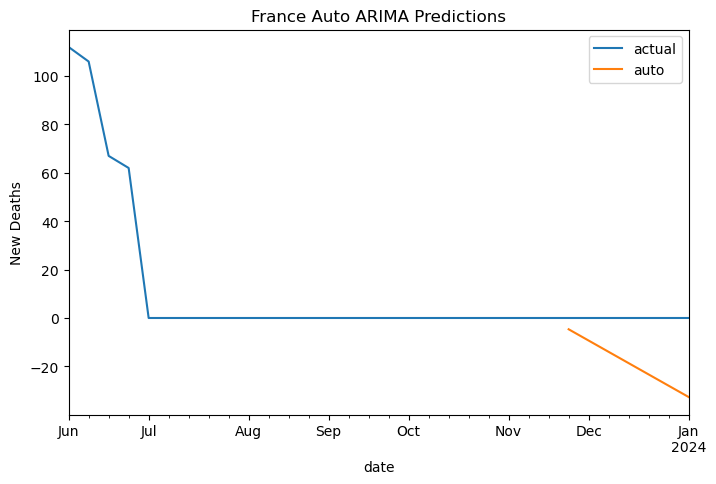

In [8]:
# train test split
# get only dates past June 1, 2023
df = france
df = df[df.index > '2023-06-01']
end = len(df) - 1
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
# baseline
model = ARIMA(train['new_deaths'], order=(1,1,1))
model_fit = model.fit()
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
france_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# grid search for p and q 
results = []
for p in range(1, 5):
    for q in range(1, 5): 
        model = ARIMA(train['new_deaths'], order=(p,1,q)).fit()
        results.append([p, q, model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p', 'q', 'aic']
results_df = results_df.sort_values('aic')
p, q = results_df.iloc[0, 0], results_df.iloc[0, 1]
model = ARIMA(train['new_deaths'], order=(p,1,q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end=end, dynamic=True)
france_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# seasonal ARIMA
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results = []
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p,1,q), seasonal_order=(P,1,Q,13)).fit(disp=False)
                    results.append([p, q, P, Q, model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p, q, P, Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 1, q), seasonal_order=(P,1,Q,13))
model_fit = model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
france_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods = len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
france_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# plots
# plot after the date June 1, 2023

france_df[france_df.index > '2023-06-01'][['actual', 'baseline']].plot(figsize=(8, 5))
plt.title('France Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

france_df[france_df.index > '2023-06-01'][['actual', 'grid_search']].plot(figsize=(8, 5))
plt.title('France Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

france_df[france_df.index > '2023-06-01'][['actual', 'seasonal']].plot(figsize=(8, 5))
plt.title('France Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

france_df[france_df.index > '2023-06-01'][['actual', 'auto']].plot(figsize=(8, 5))
plt.title('France Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country': 'France', 'Model': 'Baseline ARIMA', 'MAE': baseline_mae, 'MASE': baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'France', 'Model': 'Grid Search ARIMA', 'MAE': grid_search_mae, 'MASE': grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'France', 'Model': 'Seasonal ARIMA', 'MAE': seasonal_mae, 'MASE': seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'France', 'Model': 'Auto ARIMA', 'MAE': auto_mae, 'MASE': auto_mape}, ignore_index=True)


# Ireland

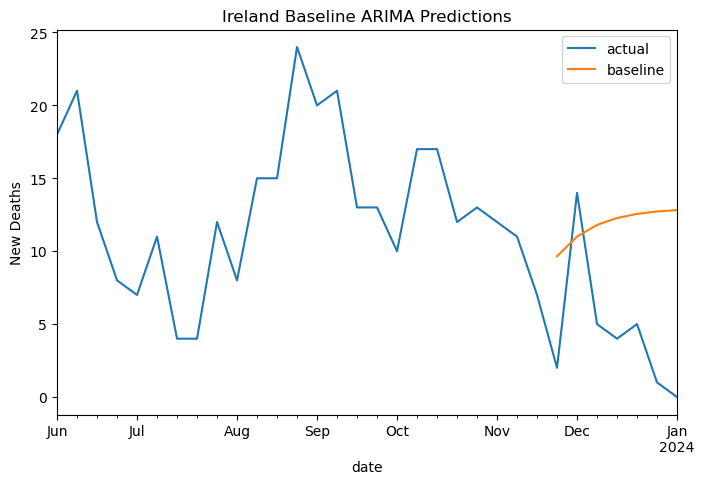

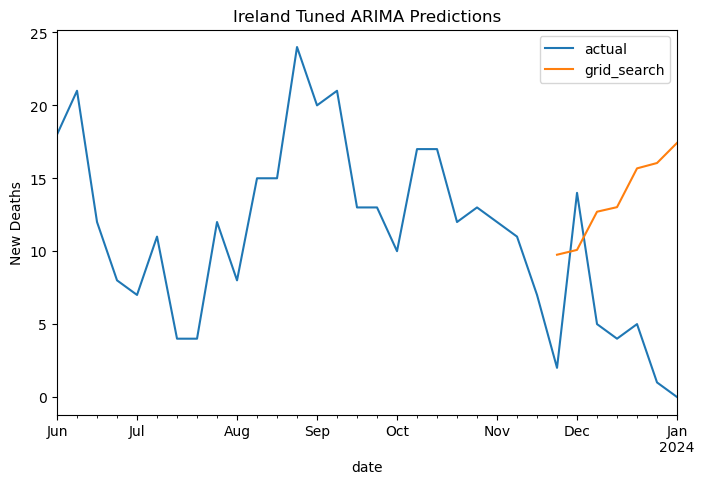

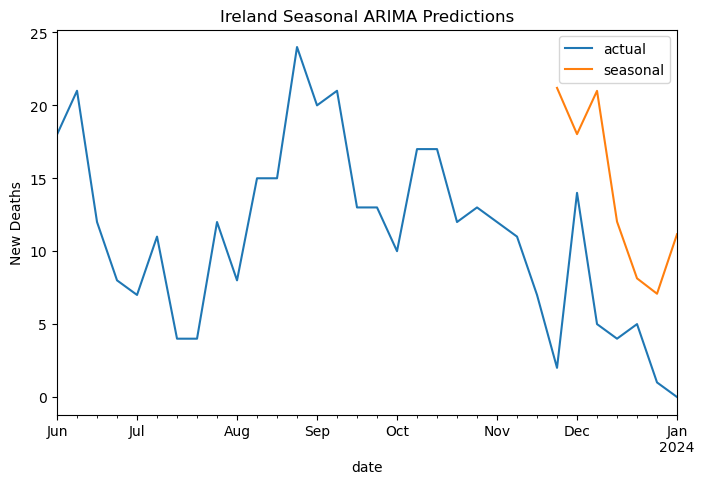

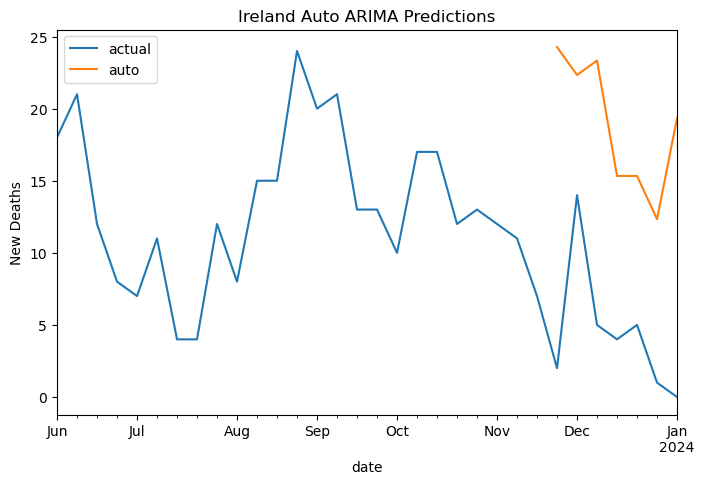

In [9]:
# train test split
# get only dates past June 1, 2023
df = ireland
df = df[df.index > '2023-06-01']
end = len(df) - 1
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
# baseline
model = ARIMA(train['new_deaths'], order=(1, 0, 1))
model_fit = model.fit()
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
ireland_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# grid search for p and q 
results = []
for p in range(1, 5):
    for q in range(1, 5): 
        model = ARIMA(train['new_deaths'], order=(p, 0, q)).fit()
        results.append([p, q, model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p', 'q', 'aic']
results_df = results_df.sort_values('aic')
p, q = results_df.iloc[0, 0], results_df.iloc[0, 1]
model = ARIMA(train['new_deaths'], order=(p, 0, q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end=end, dynamic=True)
ireland_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# seasonal ARIMA
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results = []
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 0, q), seasonal_order=(P, 1, Q, 13)).fit(disp=False)
                    results.append([p, q, P, Q, model.aic])
df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
p, q, P, Q = df_results.iloc[0, 0], df_results.iloc[0, 1], df_results.iloc[0, 2], df_results.iloc[0, 3]
model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 0, q), seasonal_order=(P, 1, Q, 13))
model_fit = model.fit(disp=False)
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
ireland_df['seasonal'] = pred
seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
seasonal_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods = len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
ireland_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# plots
ireland_df[ireland_df.index > '2023-06-01'][['actual', 'baseline']].plot(figsize=(8, 5))
plt.title('Ireland Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

ireland_df[ireland_df.index > '2023-06-01'][['actual', 'grid_search']].plot(figsize=(8, 5))
plt.title('Ireland Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

ireland_df[ireland_df.index > '2023-06-01'][['actual', 'seasonal']].plot(figsize=(8, 5))
plt.title('Ireland Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

ireland_df[ireland_df.index > '2023-06-01'][['actual', 'auto']].plot(figsize=(8, 5))
plt.title('Ireland Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country': 'Ireland', 'Model': 'Baseline ARIMA', 'MAE': baseline_mae, 'MASE': baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Ireland', 'Model': 'Grid Search ARIMA', 'MAE': grid_search_mae, 'MASE': grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Ireland', 'Model': 'Seasonal ARIMA', 'MAE': seasonal_mae, 'MASE': seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Ireland', 'Model': 'Auto ARIMA', 'MAE': auto_mae, 'MASE': auto_mape}, ignore_index=True)

# Israel

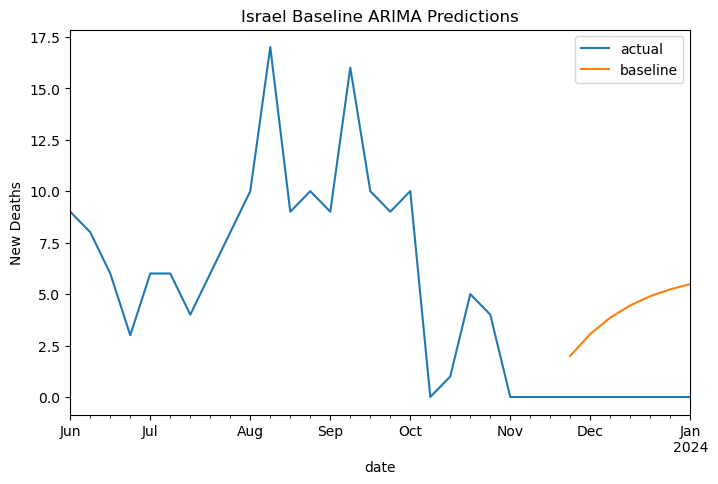

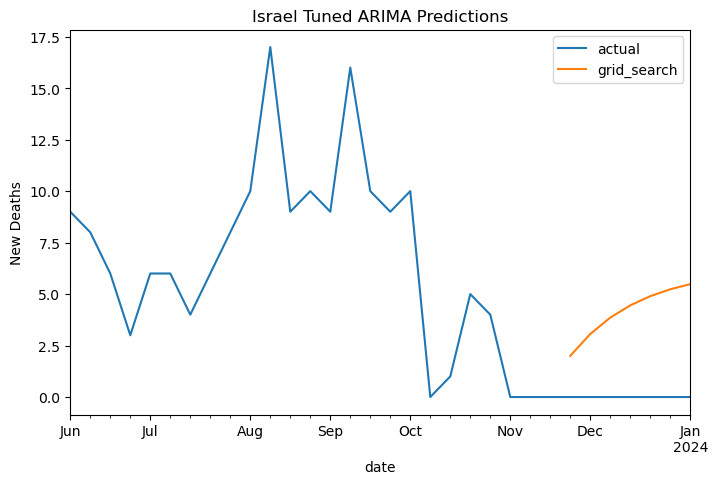

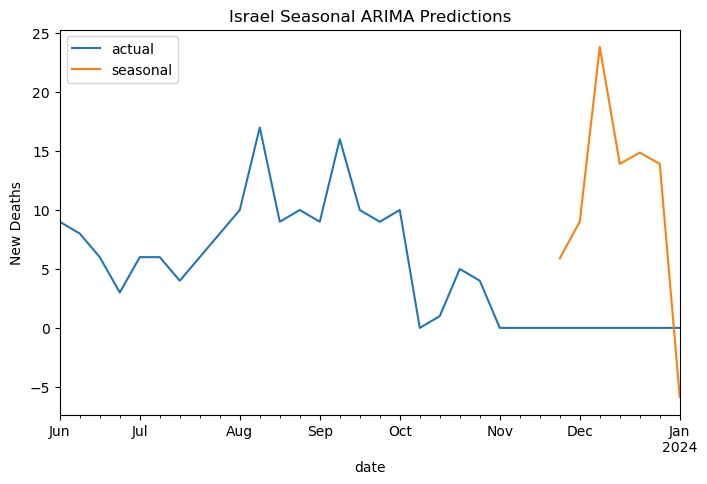

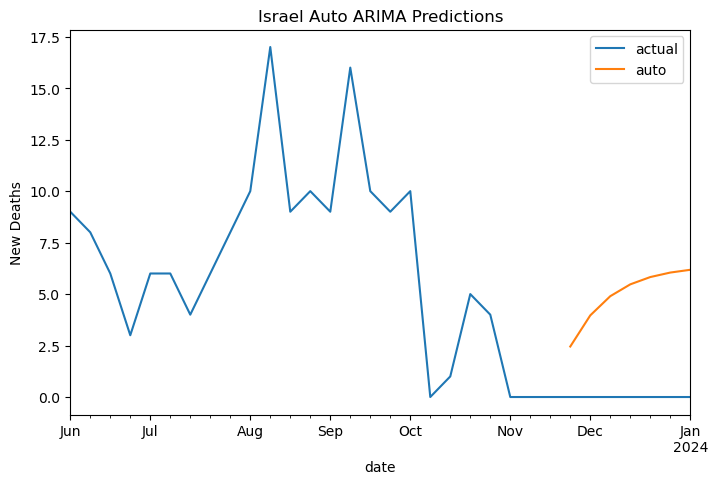

In [10]:
# train test split
# get only dates past June 1, 2023
df = israel
df = df[df.index > '2023-06-01']
end = len(df) - 1
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
# baseline
model = ARIMA(train['new_deaths'], order=(1, 0, 1))
model_fit = model.fit()
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
israel_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# grid search for p and q
results = []
for p in range(1, 5):
    for q in range(1, 5):
        model = ARIMA(train['new_deaths'], order=(p, 0, q)).fit()
        results.append([p, q, model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p', 'q', 'aic']
results_df = results_df.sort_values('aic')
p, q = results_df.iloc[0, 0], results_df.iloc[0, 1]
model = ARIMA(train['new_deaths'], order=(p, 0, q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end=end, dynamic=True)
israel_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# seasonal ARIMA
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results = []
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    model = sm.tsa.statespace.SARIMAX(train['new_deaths'],
                                                      order=(p, 0, q),
                                                      seasonal_order=(P, 1, Q, 13)).fit(disp=False)
                    results.append([p, q, P, Q, model.aic])
    df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
    p, q, P, Q = df_results.iloc[0, 0], df_results.iloc[0, 1], df_results.iloc[0, 2], df_results.iloc[0, 3]
    model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 0, q), seasonal_order=(P, 1, Q, 13))
    model_fit = model.fit(disp=False)
    pred = model_fit.predict(start=train_size, end=end, dynamic=True)
    israel_df['seasonal'] = pred
    seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
    seasonal_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods = len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
israel_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# plots
# plot after the date June 1, 2023

israel_df[israel_df.index > '2023-06-01'][['actual', 'baseline']].plot(figsize=(8, 5))
plt.title('Israel Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

israel_df[israel_df.index > '2023-06-01'][['actual', 'grid_search']].plot(figsize=(8, 5))
plt.title('Israel Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

israel_df[israel_df.index > '2023-06-01'][['actual', 'seasonal']].plot(figsize=(8, 5))
plt.title('Israel Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

israel_df[israel_df.index > '2023-06-01'][['actual', 'auto']].plot(figsize=(8, 5))
plt.title('Israel Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country': 'Israel', 'Model': 'Baseline ARIMA', 'MAE': baseline_mae, 'MASE': baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Israel', 'Model': 'Grid Search ARIMA', 'MAE': grid_search_mae, 'MASE': grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Israel', 'Model': 'Seasonal ARIMA', 'MAE': seasonal_mae, 'MASE': seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Israel', 'Model': 'Auto ARIMA', 'MAE': auto_mae, 'MASE': auto_mape}, ignore_index=True)


# Italy

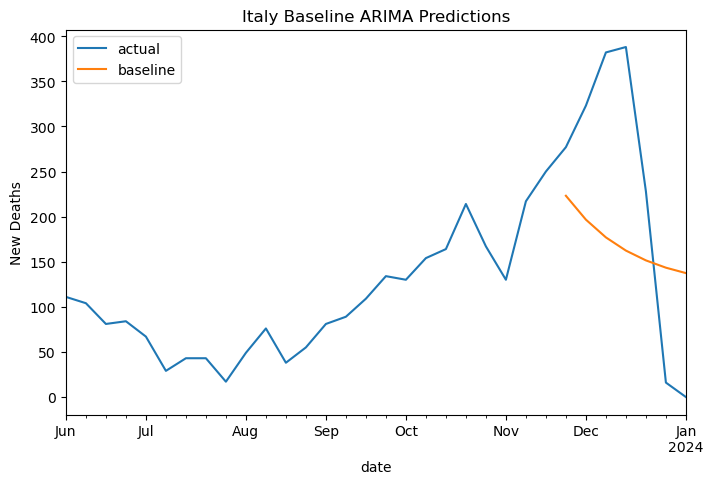

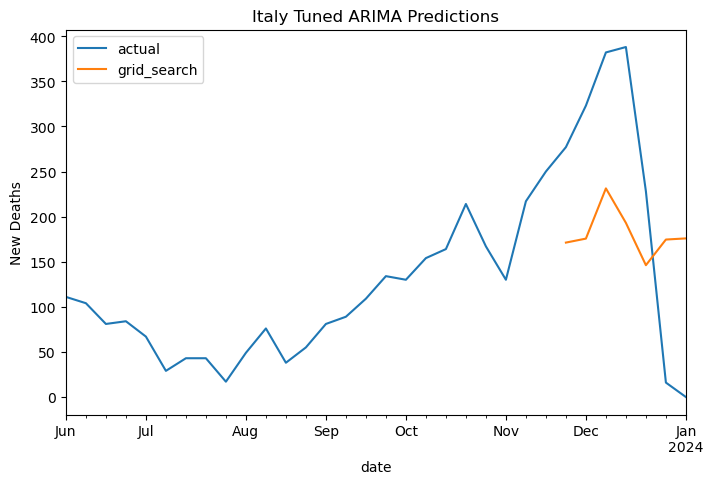

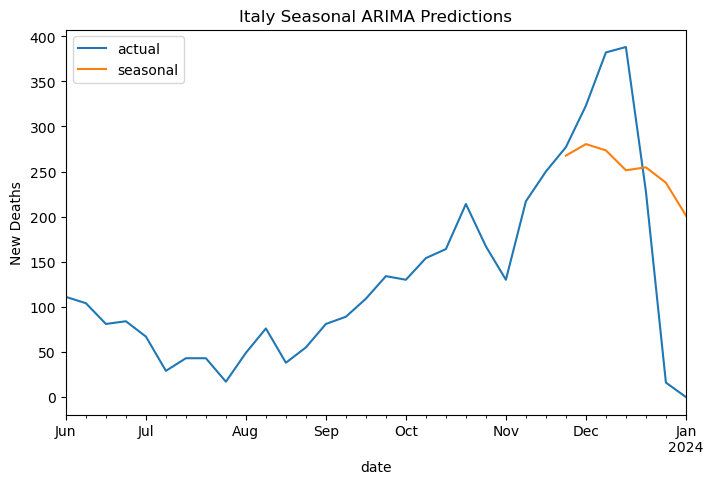

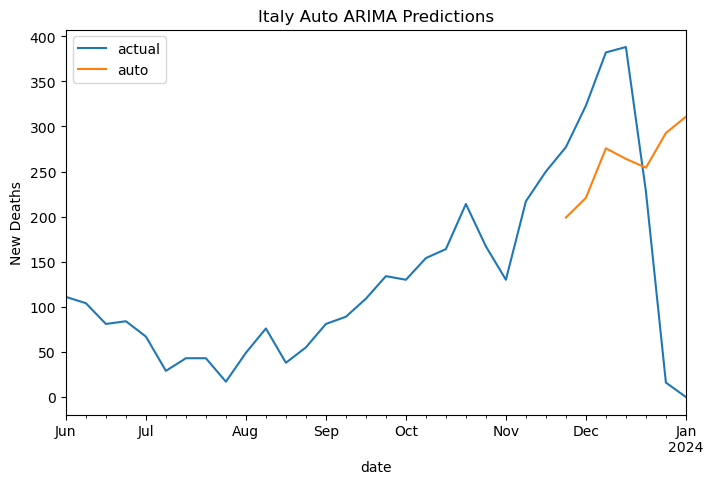

In [11]:
# train test split
# get only dates past June 1, 2023
df = italy
df = df[df.index > '2023-06-01']
end = len(df) - 1
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
# baseline
model = ARIMA(train['new_deaths'], order=(1, 0, 1))
model_fit = model.fit()
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
italy_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# grid search for p and q
results = []
for p in range(1, 5):
    for q in range(1, 5):
        model = ARIMA(train['new_deaths'], order=(p, 0, q)).fit()
        results.append([p, q, model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p', 'q', 'aic']
results_df = results_df.sort_values('aic')
p, q = results_df.iloc[0, 0], results_df.iloc[0, 1]
model = ARIMA(train['new_deaths'], order=(p, 0, q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end=end, dynamic=True)
italy_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# seasonal ARIMA
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results = []
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    model = sm.tsa.statespace.SARIMAX(train['new_deaths'],
                                                      order=(p, 0, q),
                                                      seasonal_order=(P, 1, Q, 13)).fit(disp=False)
                    results.append([p, q, P, Q, model.aic])
    df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
    p, q, P, Q = df_results.iloc[0, 0], df_results.iloc[0, 1], df_results.iloc[0, 2], df_results.iloc[0, 3]
    model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 0, q), seasonal_order=(P, 1, Q, 13))
    model_fit = model.fit(disp=False)
    pred = model_fit.predict(start=train_size, end=end, dynamic=True)
    italy_df['seasonal'] = pred
    seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
    seasonal_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods = len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
italy_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# plots
# plot after the date June 1, 2023

italy_df[italy_df.index > '2023-06-01'][['actual', 'baseline']].plot(figsize=(8, 5))
plt.title('Italy Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

italy_df[italy_df.index > '2023-06-01'][['actual', 'grid_search']].plot(figsize=(8, 5))
plt.title('Italy Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

italy_df[italy_df.index > '2023-06-01'][['actual', 'seasonal']].plot(figsize=(8, 5))
plt.title('Italy Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

italy_df[italy_df.index > '2023-06-01'][['actual', 'auto']].plot(figsize=(8, 5))
plt.title('Italy Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country': 'Italy', 'Model': 'Baseline ARIMA', 'MAE': baseline_mae, 'MASE': baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Italy', 'Model': 'Grid Search ARIMA', 'MAE': grid_search_mae, 'MASE': grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Italy', 'Model': 'Seasonal ARIMA', 'MAE': seasonal_mae, 'MASE': seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Italy', 'Model': 'Auto ARIMA', 'MAE': auto_mae, 'MASE': auto_mape}, ignore_index=True)


# Malaysia 

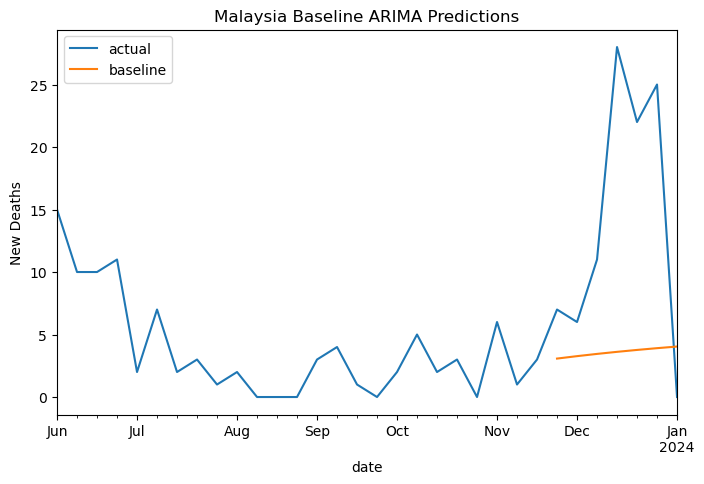

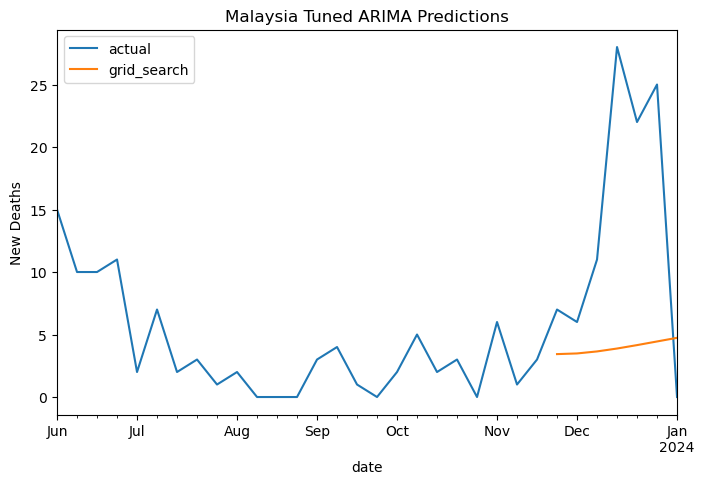

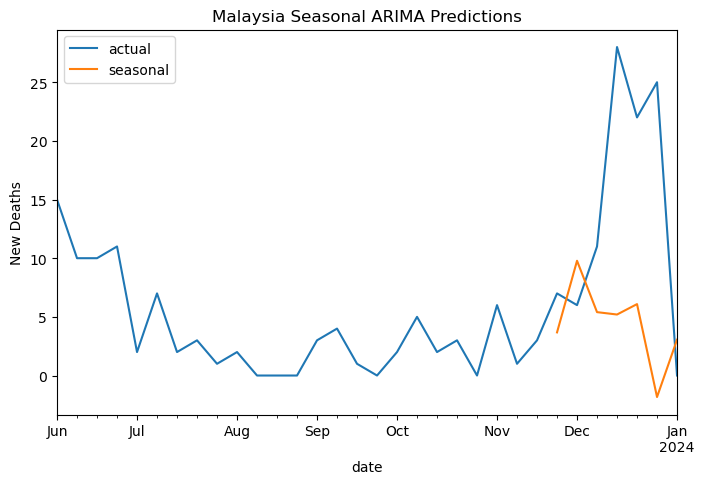

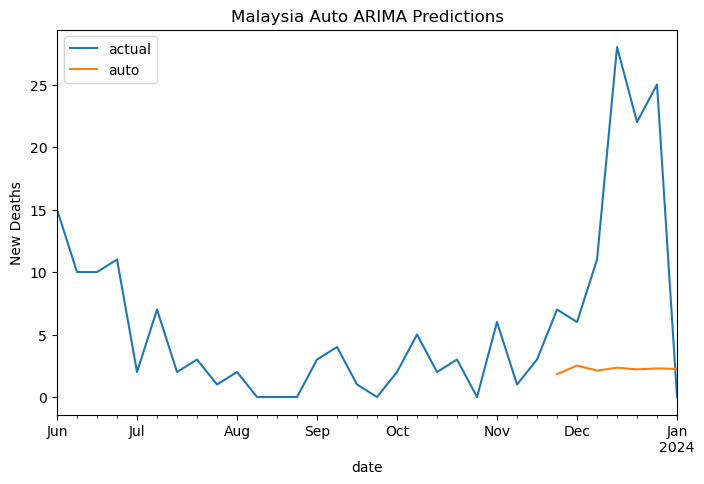

In [12]:
# train test split
# get only dates past June 1, 2023
df = malaysia
df = df[df.index > '2023-06-01']
end = len(df) - 1
train_size = int(len(df) * 0.8)
train, test = df[0:train_size], df[train_size:]

warnings.filterwarnings("ignore")
# baseline
model = ARIMA(train['new_deaths'], order=(1, 0, 1))
model_fit = model.fit()
pred = model_fit.predict(start=train_size, end=end, dynamic=True)
malaysia_df['baseline'] = pred
baseline_mae = mean_absolute_error(test['new_deaths'], pred)
baseline_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# grid search for p and q
results = []
for p in range(1, 5):
    for q in range(1, 5):
        model = ARIMA(train['new_deaths'], order=(p, 0, q)).fit()
        results.append([p, q, model.aic])
results_df = pd.DataFrame(results)
results_df.columns = ['p', 'q', 'aic']
results_df = results_df.sort_values('aic')
p, q = results_df.iloc[0, 0], results_df.iloc[0, 1]
model = ARIMA(train['new_deaths'], order=(p, 0, q))
model_fit = model.fit()

pred = model_fit.predict(start=train_size, end=end, dynamic=True)
malaysia_df['grid_search'] = pred
grid_search_mae = mean_absolute_error(test['new_deaths'], pred)
grid_search_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# seasonal ARIMA
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=statsmodels.tools.sm_exceptions.ValueWarning)
if 1:
    results = []
    for p in range(1, 3):
        for q in range(1, 3):
            for P in range(1, 3):
                for Q in range(1, 3):
                    model = sm.tsa.statespace.SARIMAX(train['new_deaths'],
                                                      order=(p, 0, q),
                                                      seasonal_order=(P, 1, Q, 13)).fit(disp=False)
                    results.append([p, q, P, Q, model.aic])
    df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
    p, q, P, Q = df_results.iloc[0, 0], df_results.iloc[0, 1], df_results.iloc[0, 2], df_results.iloc[0, 3]
    model = sm.tsa.statespace.SARIMAX(train['new_deaths'], order=(p, 0, q), seasonal_order=(P, 1, Q, 13))
    model_fit = model.fit(disp=False)
    pred = model_fit.predict(start=train_size, end=end, dynamic=True)
    malaysia_df['seasonal'] = pred
    seasonal_mae = mean_absolute_error(test['new_deaths'], pred)
    seasonal_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# auto arima
auto_model = auto_arima(train, seasonal=True, m=13, suppress_warnings=True, stepwise=True)
n_periods = len(test)
pred, conf_int = auto_model.predict(n_periods=n_periods, return_conf_int=True)
malaysia_df['auto'] = pred
auto_mae = mean_absolute_error(test['new_deaths'], pred)
auto_mape = mase(test['new_deaths'], pred, y_train=train['new_deaths'])

# plots
# plot after the date June 1, 2023

malaysia_df[malaysia_df.index > '2023-06-01'][['actual', 'baseline']].plot(figsize=(8, 5))
plt.title('Malaysia Baseline ARIMA Predictions')
plt.ylabel('New Deaths')

malaysia_df[malaysia_df.index > '2023-06-01'][['actual', 'grid_search']].plot(figsize=(8, 5))
plt.title('Malaysia Tuned ARIMA Predictions')
plt.ylabel('New Deaths')

malaysia_df[malaysia_df.index > '2023-06-01'][['actual', 'seasonal']].plot(figsize=(8, 5))
plt.title('Malaysia Seasonal ARIMA Predictions')
plt.ylabel('New Deaths')

malaysia_df[malaysia_df.index > '2023-06-01'][['actual', 'auto']].plot(figsize=(8, 5))
plt.title('Malaysia Auto ARIMA Predictions')
plt.ylabel('New Deaths')

# evaluation
evaluation = evaluation.append({'Country': 'Malaysia', 'Model': 'Baseline ARIMA', 'MAE': baseline_mae, 'MASE': baseline_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Malaysia', 'Model': 'Grid Search ARIMA', 'MAE': grid_search_mae, 'MASE': grid_search_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Malaysia', 'Model': 'Seasonal ARIMA', 'MAE': seasonal_mae, 'MASE': seasonal_mape}, ignore_index=True)
evaluation = evaluation.append({'Country': 'Malaysia', 'Model': 'Auto ARIMA', 'MAE': auto_mae, 'MASE': auto_mape}, ignore_index=True)


# Evaluation

In [37]:
evaluation = evaluation.round(4)
sorted_evaluation = evaluation.sort_values(by='MASE')
evaluation
# round eval values to 4 decimal places
seasonal_evaluation = evaluation[evaluation['Model'] == 'Seasonal ARIMA']
auto_evaluation = evaluation[evaluation['Model'] == 'Auto ARIMA']
baseline_evaluation = evaluation[evaluation['Model'] == 'Baseline ARIMA']
tuned_evaluation = evaluation[evaluation['Model'] == 'Grid Search ARIMA']
combined_arima = baseline_evaluation.append(tuned_evaluation)
# to csv
baseline_evaluation.to_csv('arima_evaluation.csv', index=False)
auto_evaluation.to_csv('auto_evaluation.csv', index=False)
seasonal_evaluation.to_csv('seasonal_evaluation.csv', index=False)
# round eval values to 4 decimal places

In [47]:
# get median values for mae and mase in baselin_evaluation
auto_evaluation.mean()


MAE     63.20894
MASE     1.63410
dtype: float64

In [14]:
# def get_df_name(df):
#     name =[x for x in globals() if globals()[x] is df][0]
#     return name
# # arima loop for countries with differencing 
# country_list_differenced = [czechia, estonia, france, malaysia, us]

# baseline_predictions = {'czechia':[], 'estonia':[], 'france':[], 'malaysia':[], 'us': [], 'belgium':[], 'chile':[], 'ireland':[], 'israel':[], 'italy':[]}
# grid_search_predictions = {'czechia':[], 'estonia':[], 'france':[], 'malaysia':[], 'us': [], 'belgium':[], 'chile':[], 'ireland':[], 'israel':[], 'italy':[]}
# seasonal_predictions = {'czechia':[], 'estonia':[], 'france':[], 'malaysia':[], 'us': [], 'belgium':[], 'chile':[], 'ireland':[], 'israel':[], 'italy':[]}

# for country in country_list_differenced:
#     train, test = country[0:train_size], country[train_size:]
#     # baseline ARIMA 
#     warnings.filterwarnings("ignore")
#     model = ARIMA(train['new_deaths'], order=(1,1,1))
#     model_fit = model.fit()
#     baseline_pred =model_fit.predict(start=train_size,end = 201, dynamic=True)
#     baseline_predictions[get_df_name(country)] = baseline_pred
#     # grid search for best p and q
#     results = []
#     for p in range(1,5):
#         for q in range(1,5): 
#             model = ARIMA(train['new_deaths'], order=(p,1,q)).fit()
#             results.append([p,q,model.aic])
#     results_df = pd.DataFrame(results)
#     results_df.columns = ['p','q','aic']
#     results_df = results_df.sort_values('aic')
#     p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
#     # grid search ARIMA 
#     model = ARIMA(train['new_deaths'], order=(p,1,q))
#     model_fit = model.fit()
#     grid_search_pred = model_fit.predict(start=train_size, end = 201,dynamic=True)
#     grid_search_predictions[get_df_name(country)] = grid_search_pred
#     # seasonal ARIMA
#     warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
#     warnings.filterwarnings("ignore",category =  UserWarning)
#     warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
#     if 1:
#         results=[]
#         for p in range(1,3):
#             for q in range(1,3):
#                 for P in range(1,3):
#                     for Q in range(1,3):
#                         model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,1,q), seasonal_order=(P,1,Q,4)).fit()
#                         results.append([p,q,P,Q,model.aic])
#     df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
#     p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
#     model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 1, q),seasonal_order=(P,1,Q,12))
#     model_fit=model.fit()
#     seasonal_pred = model_fit.predict(start=train_size, end=201, dynamic=True)
#     seasonal_predictions[get_df_name(country)] = seasonal_pred

# # arima loop for countries without differencing 

# country_list = [belgium, chile, ireland, israel, italy] 
# for country in country_list:
#     train, test = country[0:train_size], country[train_size:]
#     # baseline ARIMA 
#     warnings.filterwarnings("ignore")
#     model = ARIMA(train['new_deaths'], order=(1,0,1))
#     model_fit = model.fit()
#     baseline_pred =model_fit.predict(start=train_size,end = 201, dynamic=True)
#     baseline_predictions[get_df_name(country)] = baseline_pred
#     # grid search for best p and q
#     results = []
#     for p in range(1,5):
#         for q in range(1,5): 
#             model = ARIMA(train['new_deaths'], order=(p,0,q)).fit()
#             results.append([p,q,model.aic])
#     results_df = pd.DataFrame(results)
#     results_df.columns = ['p','q','aic']
#     results_df = results_df.sort_values('aic')
#     p,q,= results_df.iloc[0,0], results_df.iloc[0,1]
#     # grid search ARIMA 
#     model = ARIMA(train['new_deaths'], order=(p,0,q))
#     model_fit = model.fit()
#     grid_search_pred = model_fit.predict(start=train_size, end = 201,dynamic=True)
#     grid_search_predictions[get_df_name(country)] = grid_search_pred
#     # seasonal ARIMA
#     warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ConvergenceWarning)
#     warnings.filterwarnings("ignore",category =  UserWarning)
#     warnings.filterwarnings("ignore",category = statsmodels.tools.sm_exceptions.ValueWarning)
#     if 1:
#         results=[]
#         for p in range(1,3):
#             for q in range(1,3):
#                 for P in range(1,3):
#                     for Q in range(1,3):
#                         model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p,0,q), seasonal_order=(P,1,Q,4),enforce_stationarity=False).fit()
#                         results.append([p,q,P,Q,model.aic])
#     df_results = pd.DataFrame(results, columns=['p', 'q', 'P', 'Q', 'aic']).sort_values('aic')
#     p,q,P,Q = df_results.iloc[0,0], df_results.iloc[0,1], df_results.iloc[0,2], df_results.iloc[0,3]
#     model=sm.tsa.statespace.SARIMAX(train['new_deaths'],order=(p, 0, q),seasonal_order=(P,1,Q,12))
#     model_fit=model.fit()
#     seasonal_pred = model_fit.predict(start=train_size, end=201, dynamic=True)
#     seasonal_predictions[get_df_name(country)] = seasonal_pred


ADF Test Statistic : -2.5252838085816958
p-value : 0.10944306442755447
#Lags Used : 7
Number of Observations Used : 194
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 
None
ADF Test Statistic : -7.154085375650149
p-value : 3.0869768235518104e-10
#Lags Used : 6
Number of Observations Used : 194
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary
None


<Axes: xlabel='date'>

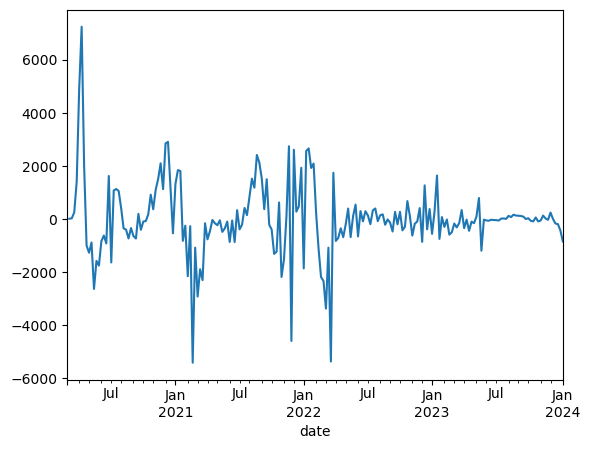

In [15]:
# checking stationarity
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(x):
    result=adfuller(x)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
print(adfuller_test(us['new_deaths']))
print(adfuller_test(us_diff['new_deaths'].dropna()))
us_diff['new_deaths'].plot()

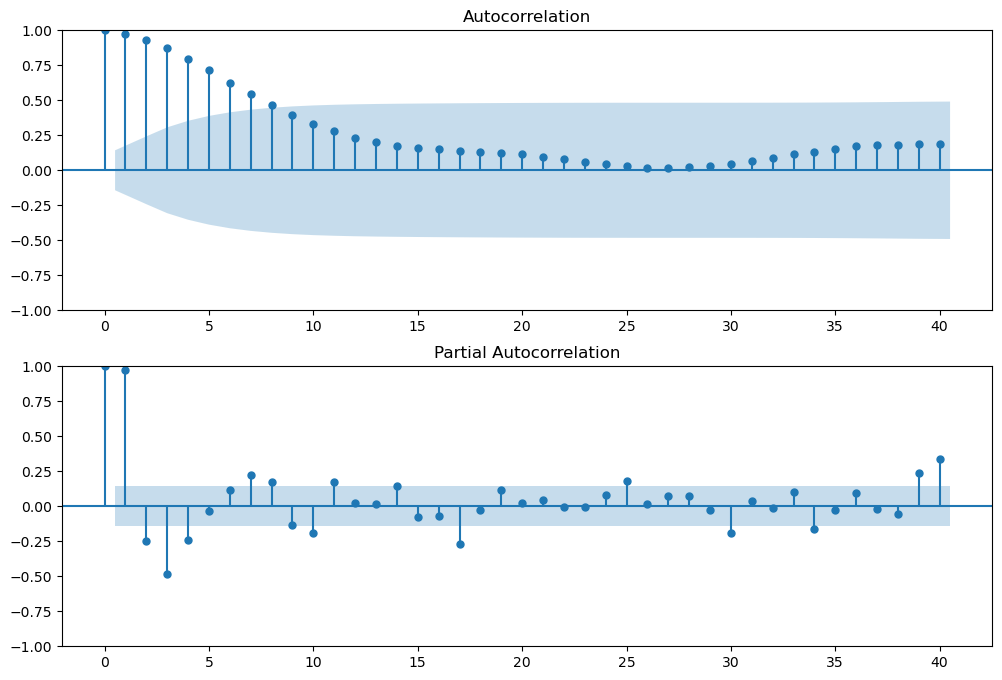

In [16]:
# ACF and PACF plots
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(us['new_deaths'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(us['new_deaths'].iloc[13:],lags=40,ax=ax2)

## Seaonality

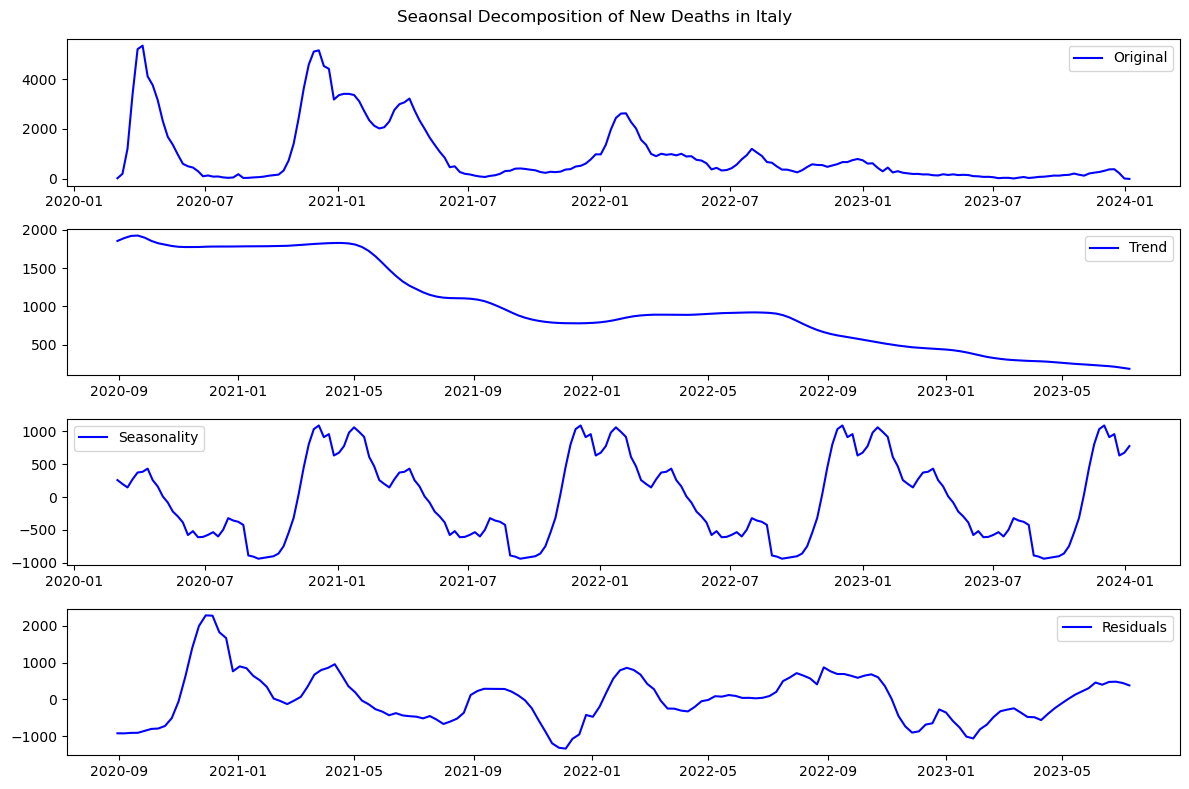

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
df = italy
decomposition = seasonal_decompose(df) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df['new_deaths'], label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.suptitle('Seaonsal Decomposition of New Deaths in Italy')
plt.tight_layout()